<a href="https://colab.research.google.com/github/damiangohrh123/ml_projects/blob/main/classification/Fashion_MNIST_CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Fashion-MNIST CNN Classifier (Deep Learning Project)

In this project, we'll be using PyTorch to classify clothing images from the Fashion-MNIST dataset.

In [44]:
# !pip install torch torchvision matplotlib --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


##Step 1: Data Loading & Preprocessing
We'll use the FashionMNIST dataset (60,000 training + 10,000 test images) provided by `torchvision.datasets`, which downloads the data automatically. Each image is 28×28 pixels, grayscale, and represents one of 10 clothing categories: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot.

We apply data transformations:

- Training set: random horizontal flips and small rotations for augmentation, convert to tensor, normalize to `[-1, 1]`

- Test set: convert to tensor and normalize to `[-1, 1]` (no augmentation)

In [45]:
# Data augmentation: helps model generalize by randomly altering training images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Test data should NOT be augmented
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Class labels
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Step 2: Visualize Sample Training Images
Before training, it's helpful to inspect some samples to understand what the data looks like.

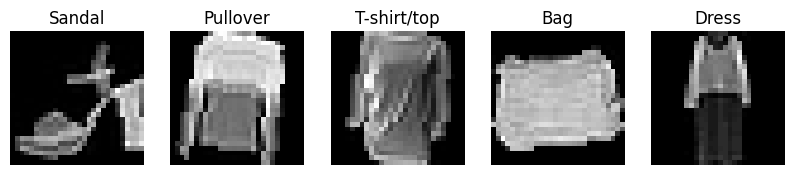

In [46]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(classes[labels[i].item()])
    axes[i].axis('off')
plt.show()

## Step 3: Define CNN Architecture
We define a CNN model with the following structure:

1. Two convolutional blocks, each containing:
    * Convolutional layer → extracts feature maps
    * ReLU activation → introduces non-linearity
    * MaxPooling → downsamples spatial dimensions
    * Dropout → prevents overfitting

2. Flatten layer → converts feature maps into a 1D vector
3. Fully connected layers with dropout for regularization
4. Output layer → produces 10 outputs, one for each clothing category

This architecture allows the network to learn hierarchical features from the images, starting from edges and textures in early layers to higher-level clothing patterns in later layers.


In [47]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.network = nn.Sequential(
            # First convolutional block:
            # Input: 1 channel (grayscale), Output: 32 channels (feature maps)
            # Kernel: 3x3, padding=1 (keeps spatial size 28x28)
            # ReLU activation, 2x2 max pooling (downsamples to 14x14), 25% dropout
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Second convolutional block: input 32 channels, Output: 64 channels (feature maps)
            # Kernel: 3x3, padding=1 (keeps spatial size 14x14)
            # ReLU activation, 2x2 max pooling (downsamples to 7x7), 25% dropout
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Flatten the 3D feature maps (64x7x7) into a 1D vector of size 3136
            nn.Flatten(),

            # Fully connected (dense) layer:
            # Input: 3136 features, Output: 128 features
            # ReLU activation and 50% dropout for regularization
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Output layer:
            # Input: 128 features, Output: 10 classes (for FashionMNIST)
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.network(x)

model = CNNClassifier().to(device)
print(model)


CNNClassifier(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Step 4: Define Loss Function and Optimizer
Use CrossEntropyLoss as the loss function and Adam as the optimizer.

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 5: Training Loop
Train the CNN for a set number of epochs. For each batch, perform a forward pass, compute loss, perform backward pass, and update model parameters. Track training loss and accuracy per epoch.


In [49]:
epochs = 7
train_losses, train_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Accuracy: {accuracy*100:.2f}%")

Epoch [1/7] - Loss: 0.6750 - Accuracy: 75.43%
Epoch [2/7] - Loss: 0.4751 - Accuracy: 82.62%
Epoch [3/7] - Loss: 0.4281 - Accuracy: 84.52%
Epoch [4/7] - Loss: 0.4022 - Accuracy: 85.50%
Epoch [5/7] - Loss: 0.3790 - Accuracy: 86.20%
Epoch [6/7] - Loss: 0.3663 - Accuracy: 86.81%
Epoch [7/7] - Loss: 0.3570 - Accuracy: 87.00%


## Step 6: Plot Training Loss and Accuracy
Plot the training loss and accuracy curves over epochs.


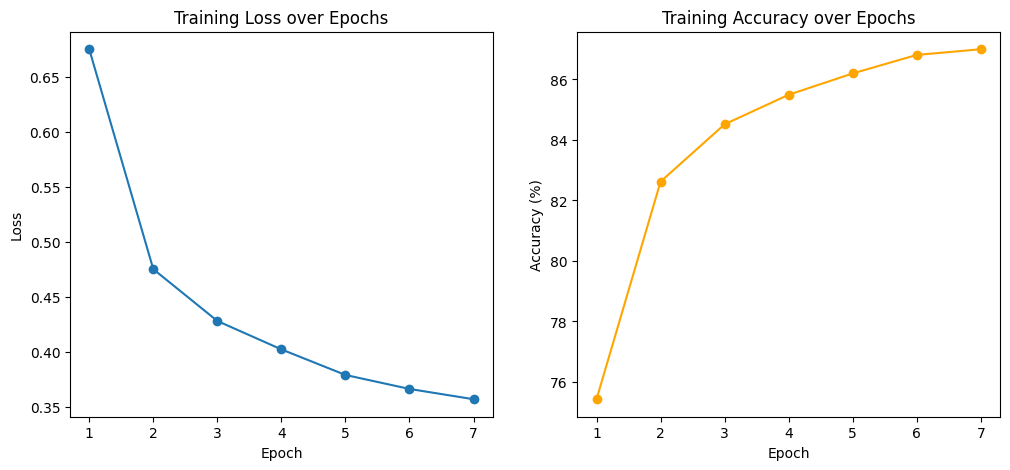

In [50]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), [a*100 for a in train_accuracies], marker='o', color='orange')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()

## Step 7: Evaluate on Test Set
Compute test accuracy by performing a forward pass on all test batches without tracking gradients.

In [51]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 89.47%


## Step 8: Visualize Predictions
Display a small batch of test images along with their predicted and true labels.

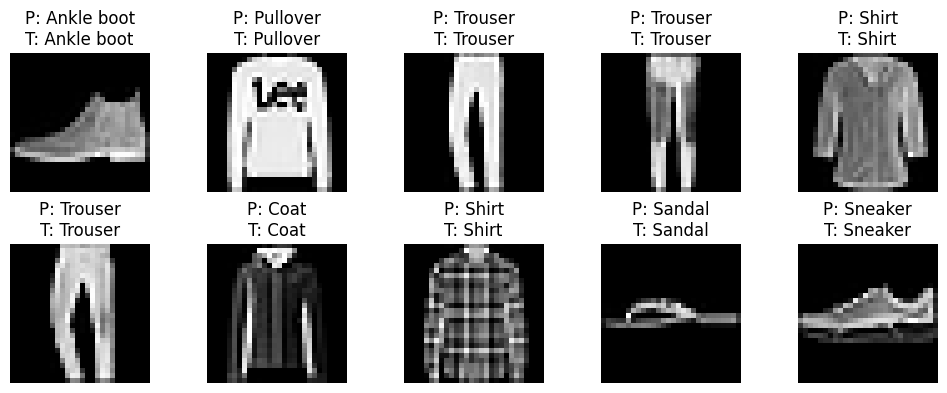

In [52]:
def show_predictions():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f"P: {classes[preds[i].item()]}\nT: {classes[labels[i].item()]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions()

## Conclusion
CNN trained with data augmentation and dropout on Fashion-MNIST. Trained model achieves test accuracy around 87–91%. Next steps could include batch normalization, deeper networks, or switching to CIFAR-10.